In [0]:
# Importing the good old libraries and modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


import os
print(os.listdir("../input"))

['digit-recognizer']


In [0]:
# importing just the pytorch modules
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

**All the optimizers that can be tried for this problem**

In [0]:
# For me, the plain vanilla Adam worked just fine
help(optim)

Help on package torch.optim in torch:

NAME
    torch.optim

DESCRIPTION
    :mod:`torch.optim` is a package implementing various optimization algorithms.
    Most commonly used methods are already supported, and the interface is general
    enough, so that more sophisticated ones can be also easily integrated in the
    future.

PACKAGE CONTENTS
    adadelta
    adagrad
    adam
    adamax
    adamw
    asgd
    lbfgs
    lr_scheduler
    optimizer
    rmsprop
    rprop
    sgd
    sparse_adam

FILE
    /opt/conda/lib/python3.6/site-packages/torch/optim/__init__.py




In [0]:
# importing the dataset
df=pd.read_csv("../input/digit-recognizer/train.csv")

****Data Preprocessing****

In [0]:
# Converting to numpy array

X=df.iloc[:,1:].values
Y=df.iloc[:,0].values

In [0]:
# Splitting the dataset into training and testing sets

from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.1,stratify=Y,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(37800, 784) (4200, 784) (37800,) (4200,)


In [0]:
#StandardScaling the data

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [0]:
# Converting Numpy arrays to Pytorch Tensors after applying scaling

X_train,X_val,Y_train,Y_val = map(torch.tensor,(X_train,X_val,Y_train,Y_val))

**Creating Feedforward Network class**

In [0]:
class FFNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net= nn.Sequential(nn.Linear(784,1024),nn.Sigmoid(),nn.Linear(1024,10),nn.Softmax())
        
    def forward(self,X):
        return self.net(X)

In [0]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

In [0]:
def fit(x, y, model, l_r, epochs=1000, mini_batch_size = 1024):
    loss_arr=[]
    loss_per_epoch=[]
    acc_arr=[]
    opt=optim.Adam(fn.parameters(),lr= l_r)
    m = x.shape[0]
    for epochs in range(epochs):
        for k in range(0, m, mini_batch_size):
            x_mini , y_mini = x[k:k+mini_batch_size], y[k:k+mini_batch_size]
            y_hat=fn(x_mini.float())
            loss=F.cross_entropy(y_hat, y_mini)
            loss_arr.append(loss.item())
            acc_arr.append(accuracy(y_hat, y_mini))
            loss.backward()
            opt.step()
            opt.zero_grad()
        loss_per_epoch.append(loss.item())
    plt.plot(loss_per_epoch, 'r')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    print('Accuracy', acc_arr[-1])

In [0]:
#Taking data to GPU
device = torch.device("cuda")
X_train=X_train.to(device)
Y_train=Y_train.to(device)
X_val=X_val.to(device)
Y_val=Y_val.to(device)

In [0]:
X_train.shape[0]

37800

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


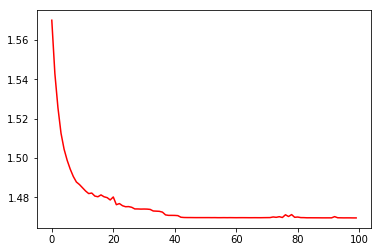

Loss before training 2.3045949935913086
Loss after training 1.4695910215377808
Accuracy tensor(0.9915, device='cuda:0')
Test accuracy: tensor(0.9586, device='cuda:0')


In [0]:
fn = FFNetwork()
fn.to(device)
#Training on training data
fit(X_train, Y_train, fn, l_r= 0.003, epochs=100)
print("Test accuracy:",accuracy(fn(X_val.float()), Y_val))

***Creating Confusion Matrix***

In [0]:
Y_pred_val=fn(X_val.float())
Y_pred_val = torch.argmax(Y_pred_val, dim=1)
cm= confusion_matrix(Y_pred_val.cpu(), Y_val.cpu())
print(cm)

[[399   0   2   0   1   2   3   1   0   0]
 [  0 460   1   1   1   0   1   3   1   0]
 [  1   3 388   7   4   0   1   5   1   0]
 [  1   1   6 406   0   5   0   0   4   5]
 [  2   2   4   0 394   0   2   3   2   5]
 [  3   0   3   4   0 365   4   0   4   1]
 [  4   0   2   1   2   1 401   0   3   0]
 [  1   2   5   5   0   2   0 424   0   7]
 [  1   0   6   5   0   4   2   0 389   1]
 [  1   0   1   6   5   1   0   4   2 400]]


In [0]:
df_test=pd.read_csv("../input/digit-recognizer/test.csv")
X_test=df_test.values
X_test=sc.transform(X_test)
X_test=torch.from_numpy(X_test).to(device)

In [0]:
type(X_test)

torch.Tensor

In [0]:
Y_pred_test=fn(X_test.float())
Y_pred_test = torch.argmax(Y_pred_test, dim=1)

submission = {}
submission['ImageId'] = np.array(range(1,X_test.shape[0]+1))
submission['Label'] = Y_pred_test.cpu()

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Label']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)